In [1]:
# A simple example on how to train a model and perform planning to solve a goal-conditioned task

from Utils.Utils import *
from Models.Models import *
from tqdm import trange
from Planning.Planning_alg import Planner

In [2]:
config= {
    "seed": 0,
    "in_d": 2,
    "out_d": 2,
    "in_dist_d": 8, # parameter of the WideNorm
    "out_dist_d": 8, # parameter of the WideNorm
    "dist_type": "WideNorm", # "WideNorm" or "L1" 
    "l_rate": 0.0005,
    "amsgrad": True,
    "batch_size_o": 64,
    "batch_size_c": 512,
    "max_dist_obj": None,
    "dist_discount": 0.97,
    "max_dist_con": 1,
    "weight_constrains": 10,
    "gradient_steps": 1000,
    "in_a_d": 5,
    "l_rate_action": 0.0005,
    "amsgrad_action": True,
    "batch_size_action": 128,
    "gradient_steps_action": 1000
}

In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

In [4]:
# Let's collect trajectories of a simple GridWorld
env = PointmassEnv(max_n_steps_episode=50)
trajectories, _ = collect_action_trajectories(env, 100, False, float("inf"))
trajectories_sas = convert_traj_to_sas(trajectories)

exp_rep_dist = ErDist(max_n_trajectories=10000, trajectories_list=trajectories_sas)

Add trajectories to experience replay: 100%|██████████| 100/100 [00:00<00:00, 2934.27it/s]


Loss: 112.29551 Steps of gradient: 100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]


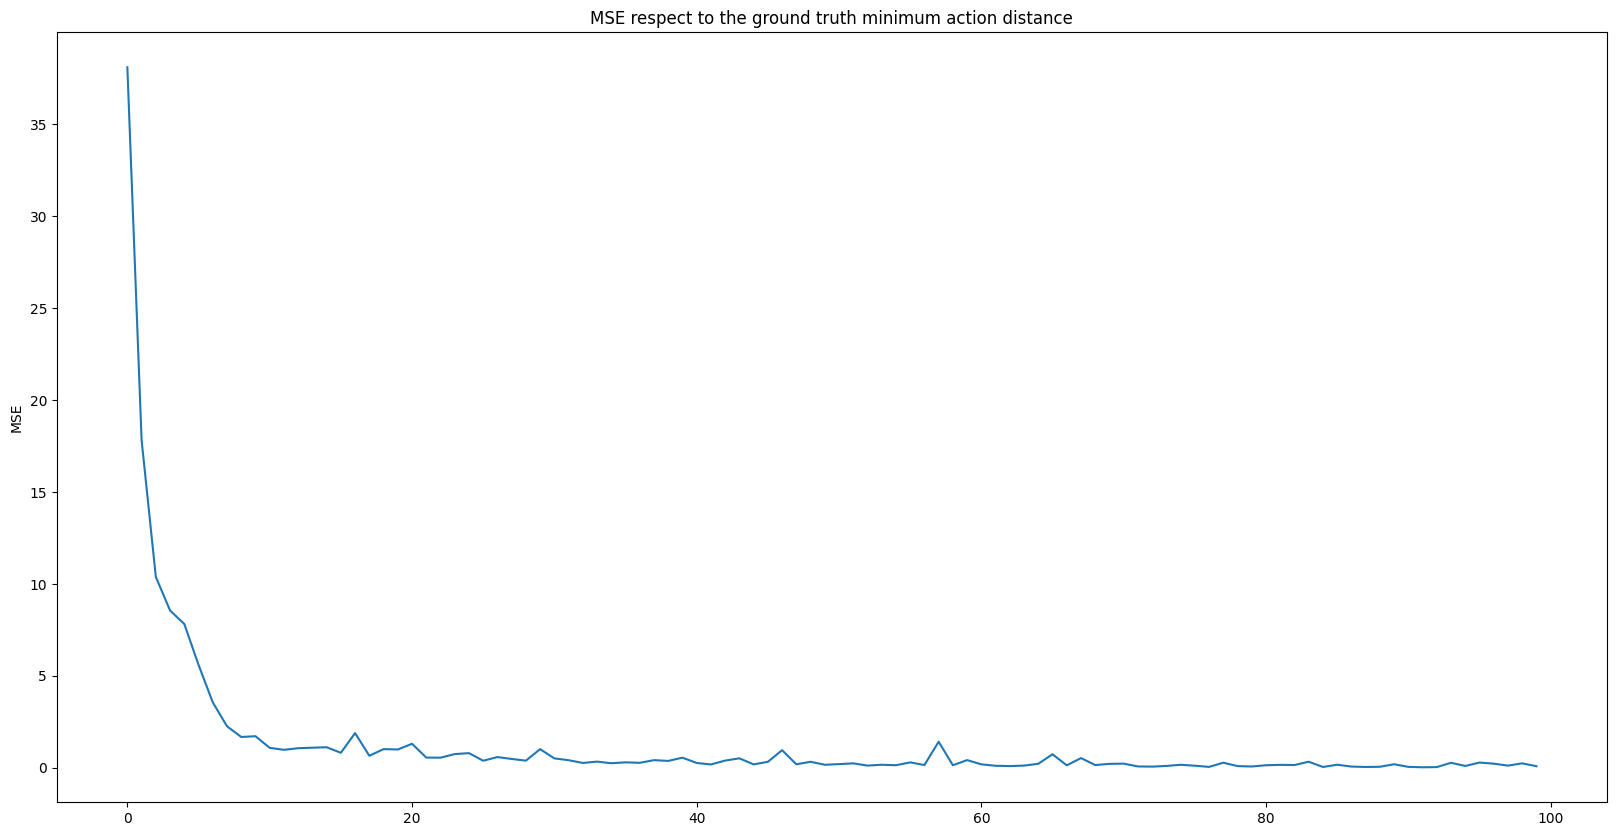

In [5]:
# Let's train the state representation model
dist_encoder_model = MlpDistEncoder(config["in_d"],
                                    config["out_d"],
                                    config["dist_type"],
                                    config["in_dist_d"],
                                    config["out_dist_d"])

optimizer = torch.optim.AdamW(dist_encoder_model.parameters(), weight_decay=0, lr=config["l_rate"], amsgrad=config["amsgrad"])

loss_list = []
mse_gt_list = []
dist_matrix_original = env.compute_MAD_distance()
t = trange(config["gradient_steps"], desc="Steps of gradient", leave=True)
for step in t:

    dist_encoder_model.train()
    loss_o, loss_c, loss = dist_encoder_model.training_step(exp_rep_dist, optimizer, config)
    loss_list.append(loss.item())
    # perform a moving average on the loss list 
    if len(loss_list) > 10:
        loss_w_avg = np.convolve(loss_list, np.ones(10), 'valid') / 10
    else:
        loss_w_avg = np.convolve(loss_list, np.ones(len(loss_list)), 'valid') / len(loss_list)
    t.set_description("Loss: %.5f Steps of gradient" % loss_w_avg[-1])
    
    if step % 10 == 0:
        # test the dist model
        dist_encoder_model.eval()
        all_states = [(i, j) for i in range(int(env.state_space.high[0])) for j in range(int(env.state_space.high[0]))]
        all_pairs_states = np.array([(i, j) for i in all_states for j in all_states])
        all_s1 = torch.from_numpy(all_pairs_states[:, 0]).float()
        all_s2 = torch.from_numpy(all_pairs_states[:, 1]).float()
        dist_pred = dist_encoder_model.dist(dist_encoder_model(all_s1), dist_encoder_model(all_s2)).detach().numpy()

        sum_e = 0
        for all_s1, s2, pred_d in zip(all_s1, all_s2, dist_pred):
            true_d = dist_matrix_original[tuple(all_s1.detach().numpy())][tuple(s2.detach().numpy())]
            sum_e += (pred_d - true_d) ** 2
            
        mse_gt_list.append(sum_e / len(dist_pred))

plt.plot(mse_gt_list)
plt.title('MSE respect to the ground truth minimum action distance')
plt.ylabel('MSE')
plt.show()

Steps of gradient: 100%|██████████| 1000/1000 [00:47<00:00, 20.90it/s]


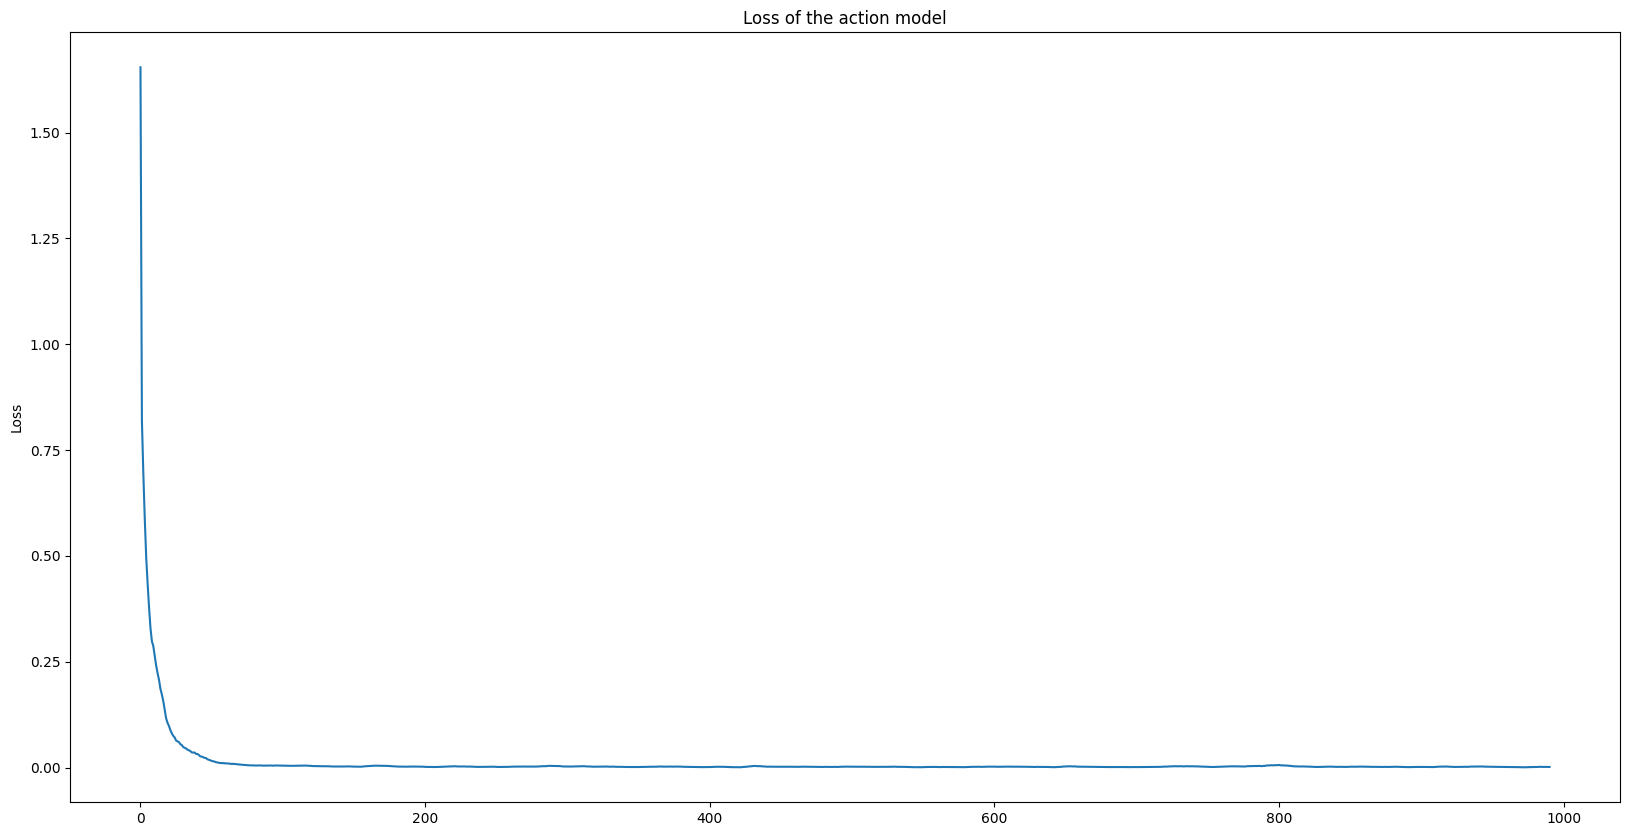

In [6]:
# Let's train the action model

action_encoder_model = ActionEncoder(config["in_a_d"], config["out_d"])

optimizer = torch.optim.AdamW(action_encoder_model.parameters(), weight_decay=0, lr=config["l_rate_action"], amsgrad=config["amsgrad"])

loss_list = []

for step in trange(config["gradient_steps_action"], desc="Steps of gradient", leave=True):

    loss = action_encoder_model.training_step(dist_encoder_model, exp_rep_dist, optimizer, config)
    loss_list.append(loss.item())

# perform a moving average on the loss list 
loss_w_avg = np.convolve(loss_list, np.ones(10), 'valid') / 100

plt.plot(loss_w_avg)
plt.title('Loss of the action model')
plt.ylabel('Loss')
plt.show()


In [9]:
model = LearnedModel(dist_encoder_model, action_encoder_model)
planner = Planner(model, list(range(env.action_space.n)), max_n_rand_traj=10, max_horizon=1)

steps = 0
sum_r = 0
for epoch in range(100):
    s = env.reset()
    desired_goal = env.get_goal()
    z_goal = planner.get_z_goal_states(np.array([desired_goal]))
    while True:
        p_a = planner.prob_multi_step_lookahead(s, z_goal, 0.1, verbose=False)
        s_, r, done, info = env.step(p_a)

        sum_r += r
        s = s_
        if done: break

    print(epoch, "sum_of_rewards: ", sum_r, "final_state: ", s, "goal_state: ", desired_goal)
    sum_r = 0


0 sum_of_rewards:  -8 final_state:  [1. 7.] goal_state:  [1. 7.]
1 sum_of_rewards:  -12 final_state:  [8. 4.] goal_state:  [8. 4.]
2 sum_of_rewards:  -8 final_state:  [4. 4.] goal_state:  [4. 4.]
3 sum_of_rewards:  -5 final_state:  [1. 4.] goal_state:  [1. 4.]
4 sum_of_rewards:  -9 final_state:  [1. 7.] goal_state:  [1. 7.]
5 sum_of_rewards:  -13 final_state:  [3. 9.] goal_state:  [3. 9.]
6 sum_of_rewards:  -11 final_state:  [4. 7.] goal_state:  [4. 7.]
7 sum_of_rewards:  -7 final_state:  [4. 3.] goal_state:  [4. 3.]
8 sum_of_rewards:  -11 final_state:  [7. 3.] goal_state:  [7. 3.]
9 sum_of_rewards:  -9 final_state:  [4. 4.] goal_state:  [4. 4.]
10 sum_of_rewards:  -7 final_state:  [4. 3.] goal_state:  [4. 3.]
11 sum_of_rewards:  -3 final_state:  [2. 1.] goal_state:  [2. 1.]
12 sum_of_rewards:  -9 final_state:  [8. 1.] goal_state:  [8. 1.]
13 sum_of_rewards:  -15 final_state:  [7. 8.] goal_state:  [7. 8.]
14 sum_of_rewards:  -7 final_state:  [7. 0.] goal_state:  [7. 0.]
15 sum_of_rewar